# Titanic Data Set

We are looking at the introductory Titanic Kaggle dataset. The task is to take in the data set and to build
an algorithm that predicts the survival of passengers in the test data set.

Learning goals:
1. Get confident with pandas data frames
2. Use visualisation to get a feeling for signal detection
3. Build some naive predictors
4. Understand the principle behind the random forrest predictor
5. Develop something new that at least does passably well

Constraints:
1. AI can be used to assist in the creation of code snippets, but should be avoided.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
import re

DATA_DIR = Path("Data") / "titanic"  # adjust if needed
train_path = DATA_DIR /"train.csv"
test_path = DATA_DIR /"test.csv"
print("Looking for:", test_path.resolve()) #Short sanity check to see where the training files should go to.
print("Exists:", test_path.exists())    #And If they exist

train_data = pd.read_csv(train_path) #Loading the data into pandas data frames.
test_data = pd.read_csv(test_path)


print(train_data.shape)
train_data.head() #First Overview Of What we have


Looking for: /Users/lassegrimmelt/PycharmProjects/PythonProject/Data/titanic/test.csv
Exists: True
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To get a feeling of the data, I would like to do some basic stastics on the numerical values.


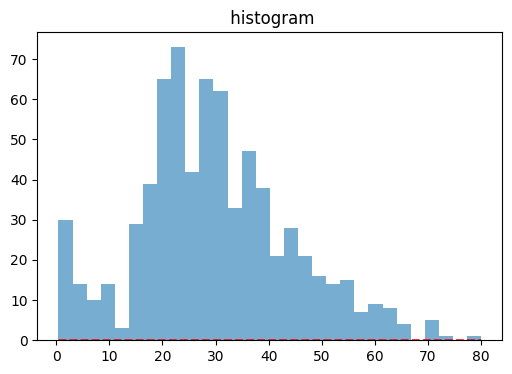

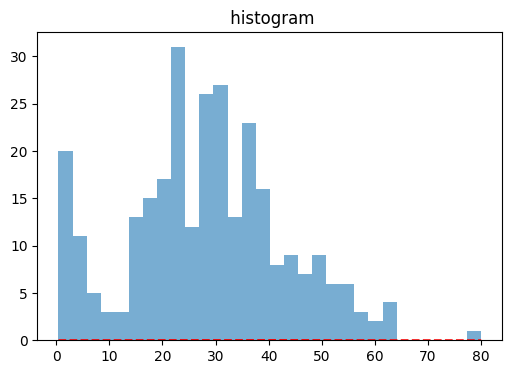

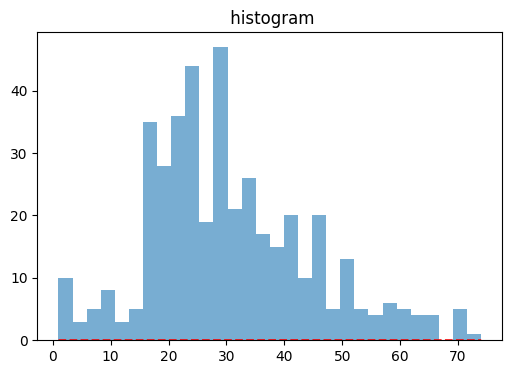

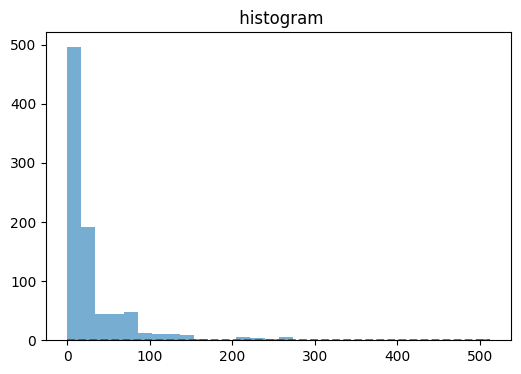

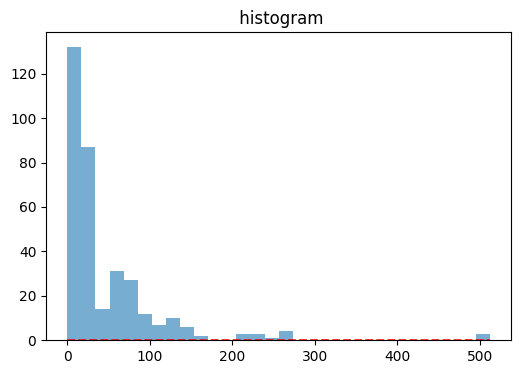

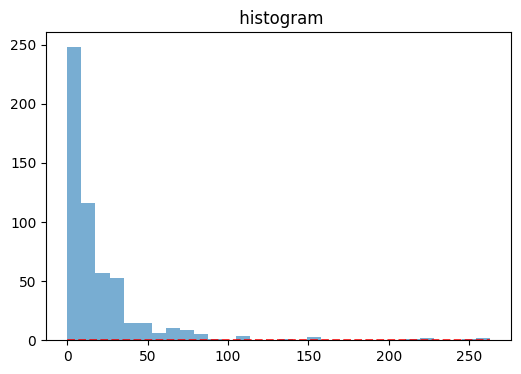

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

def plot_histogram(df):
    x = df.dropna()
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=False, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f" histogram")
    plt.show()


plot_histogram(train_data["Age"])
plot_histogram(train_data.loc[train_data["Survived"] == 1, "Age"])
plot_histogram(train_data.loc[train_data["Survived"] == 0, "Age"])

plot_histogram(train_data["Fare"])
plot_histogram(train_data.loc[train_data["Survived"] == 1, "Fare"])
plot_histogram(train_data.loc[train_data["Survived"] == 0, "Fare"])

How to build a predictor? My naive guess would be the following:
1. Choose 4-5 highly predictive cateogries
2. Split them into buckets
3. For each bucket calculate the relative survivale rate
4. Use a kernel blurring to fill gaps and smoothen out
5. Use as predictor

Gaps:
1. Buckets should be replaced by smooth versions again, maybe that would make smoothening afterwards unneccessary?
2. We assume that 'closeness in buckets' implies 'closeness in result', but that may not be the case at all. Better would be a graph based method in which adjacency is learned.


Let's start with the task and first look at relative survival rates

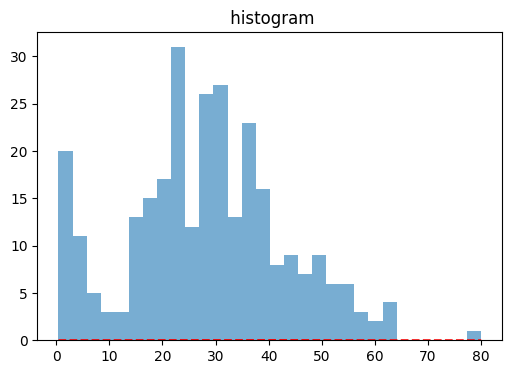

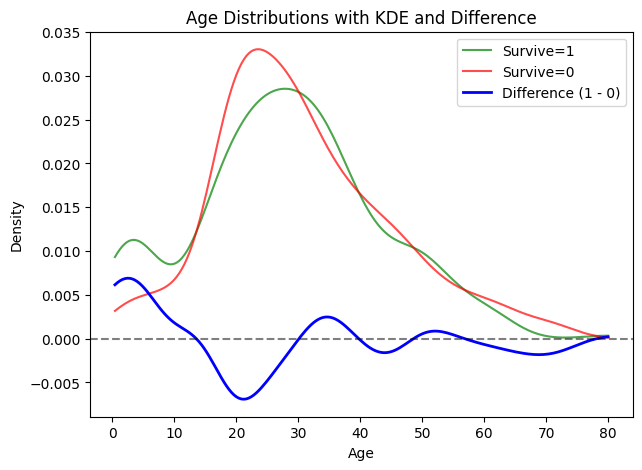

In [3]:
def plot_smooth_age_difference(df, age_col="Age", survive_col="Survived" ):
    all_ages = df[age_col].dropna()
    base_kde = gaussian_kde(all_ages)
    bw = base_kde.factor
    df = df[[age_col, survive_col]].dropna()


    # Split into survivors and non-survivors
    ages_survive1 = df.loc[df[survive_col] == 1, age_col]
    ages_survive0 = df.loc[df[survive_col] == 0, age_col]

    plot_histogram(ages_survive1)
    kde1 = gaussian_kde(ages_survive1, bw_method=bw)
    kde0 = gaussian_kde(ages_survive0, bw_method=bw)

    # Evaluation grid
    xs = np.linspace(df[age_col].min(), df[age_col].max(), 200)
    # Densities
    d1 = kde1(xs)
    d0 = kde0(xs)

    # Difference
    diff = d1 - d0

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(xs, d1, label="Survive=1", color="green", alpha=0.7)
    plt.plot(xs, d0, label="Survive=0", color="red", alpha=0.7)
    plt.plot(xs, diff, label="Difference (1 - 0)", color="blue", linewidth=2)
    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Age Distributions with KDE and Difference")
    plt.show()

plot_smooth_age_difference(train_data)



REMARK: This is actually normalised for int=1, which is nice looking but  not the right normalisation for predictor models, this is changed in the next cell.

From this we see that as first approximation grouping age into 10 year chunk should be fine, so that gives us $8$ categories. Before progression, let's first fix the relativeness and also create graphs for the other variables, that are of discrete nature.

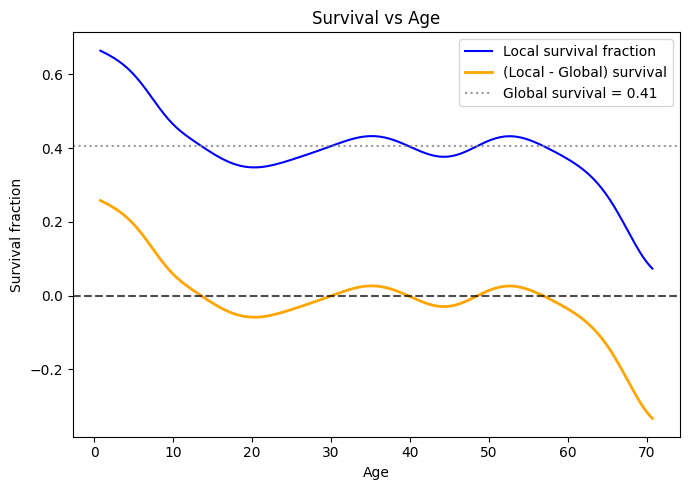

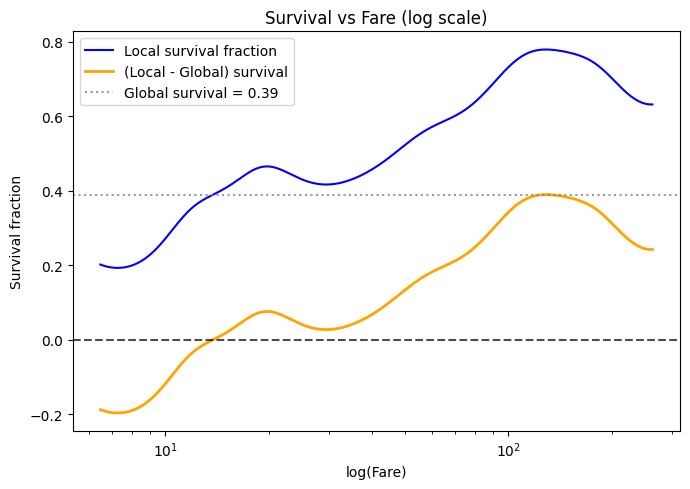

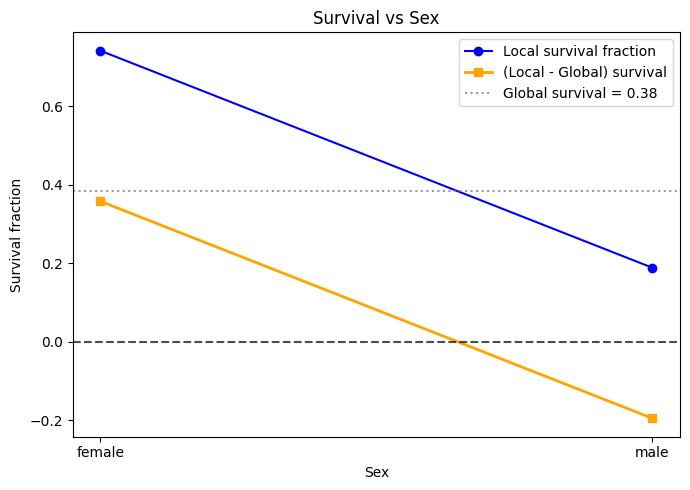

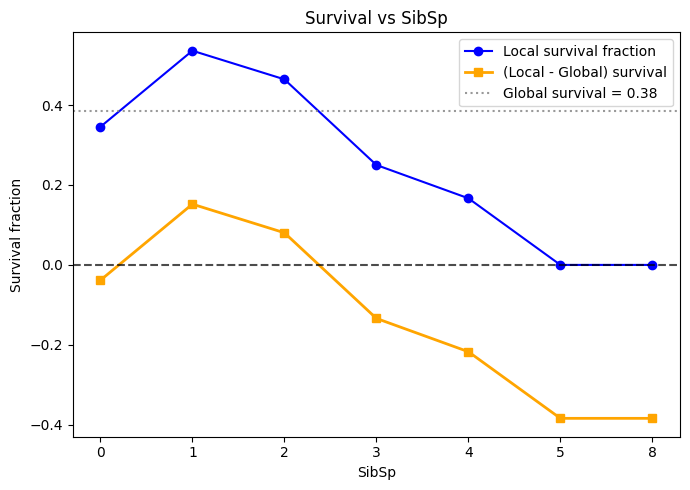

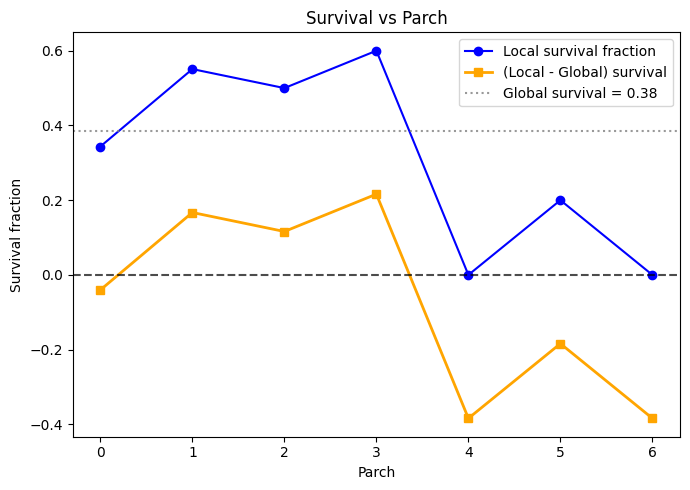

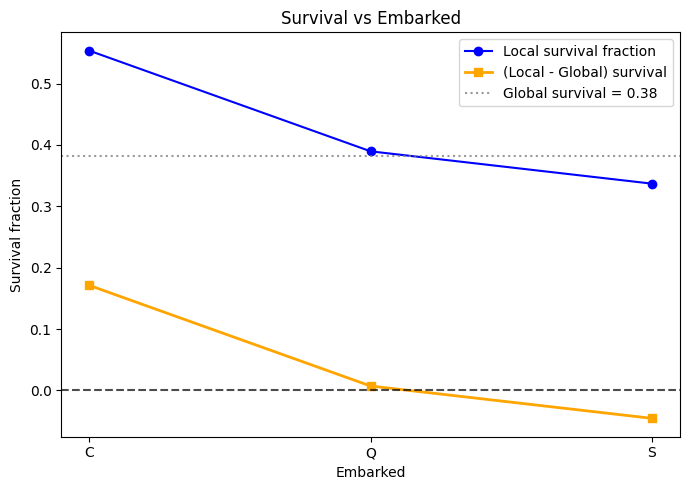

In [11]:
def plot_smooth_relative_survival(df, target_col, survive_col="Survived", logarithmic=False, min_positive=1e-8,
):
    """
    Plot KDEs of Survived=1 vs Survived=0 of Target_col, either logarithmic or not,
    and show the normalized difference: local survival rate - overall survival rate.
    """
    sub = df[[target_col, survive_col]].dropna() #Dropping NaN entry rows
    if logarithmic:
        sub = sub[sub[target_col] > min_positive] #exclude too small values in the logartihmic case
    if sub.empty:
        print("Not enough data to plot.")
        return
    # Prepare variables
    x = sub[target_col].values
    if logarithmic:
        z = np.log(x)
        xlabel = f"log({target_col})"
    else:
        z = x
        xlabel = target_col

    surv = sub[survive_col].values
    z1 = z[surv == 1]
    z0 = z[surv == 0]

    n1, n0 = len(z1), len(z0)
    if n1 < 2 or n0 < 2:
        print("Not enough data in one of the groups for KDE.")
        return
    p_global = n1 / (n1 + n0)

    # Common KDE bandwidth
    bw = gaussian_kde(z).factor
    kde1 = gaussian_kde(z1, bw_method=bw)
    kde0 = gaussian_kde(z0, bw_method=bw)

    # Evaluation grid
    zmin, zmax = np.percentile(z, [0.5, 99.5])
    zs = np.linspace(zmin, zmax, 400)
    if logarithmic:
        xs = np.exp(zs)
    else:
        xs = zs
    # Evaluate densities
    d1 = kde1(zs)
    d0 = kde0(zs)

    # Local survival fraction and difference
    local_survival = (p_global * d1) / (p_global * d1 + (1 - p_global) * d0)
    diff_norm = local_survival - p_global

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(xs, local_survival, label="Local survival fraction", color="blue")
    plt.plot(xs, diff_norm, label="(Local - Global) survival", color="orange", linewidth=2)
    if logarithmic:
        plt.xscale("log")
    plt.axhline(p_global, color="gray", linestyle=":", alpha=0.8, label=f"Global survival = {p_global:.2f}")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel("Survival fraction")
    plt.title(f"Survival vs {target_col}{' (log scale)' if logarithmic else ''}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_relative_survival_categorical(df, category_col, survive_col="Survived"):
    sub = df[[category_col, survive_col]].dropna()
    if sub.empty:
        print("Not enough data to plot.")
        return
    p_global = sub[survive_col].mean()

    group_stats = (
        sub.groupby(category_col)[survive_col]
        .agg(["mean", "count"])
        .rename(columns={"mean": "local_survival"})
    )
    group_stats["diff_from_global"] = group_stats["local_survival"] - p_global


    categories = group_stats.index.astype(str)
    local = group_stats["local_survival"].values
    diff = group_stats["diff_from_global"].values


    plt.figure(figsize=(7, 5))
    plt.plot(categories, local, label="Local survival fraction", color="blue", marker="o")
    plt.plot(categories, diff, label="(Local - Global) survival", color="orange", linewidth=2, marker="s")
    plt.axhline(p_global, color="gray", linestyle=":", alpha=0.8, label=f"Global survival = {p_global:.2f}")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.xlabel(category_col)
    plt.ylabel("Survival fraction")
    plt.title(f"Survival vs {category_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()




plot_smooth_relative_survival(train_data, "Age")
plot_smooth_relative_survival(train_data, "Fare", logarithmic=True)
plot_relative_survival_categorical(train_data, "Sex")
plot_relative_survival_categorical(train_data, "SibSp")
plot_relative_survival_categorical(train_data, "Parch")
plot_relative_survival_categorical(train_data, "Embarked")